# Explainable boosting machine fitting

## Set export to True if you wish to export graphs and tables

In [1]:
export = True
seed = 1337

In [2]:
%matplotlib inline

import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from os import listdir
from matplotlib.patches import Patch
from matplotlib.cm import get_cmap
from sklearn.cluster import KMeans
import xgboost as xgb
from itertools import product
from sklearn.linear_model import Lasso
from imblearn.over_sampling import ADASYN 
from sklearn.metrics import f1_score, confusion_matrix
from auxiliary_code.helper_functions import *


In [3]:
df_phase_fews_net = pd.read_csv(
    '../datasets/fews_net_ipc.csv', parse_dates=['date'])
set_index(df_phase_fews_net)

df_phase_fews_net.sort_index(inplace=True)
df_phase_fews_net= df_phase_fews_net.round().astype(int)

# df_ipc = pd.read_csv('../datasets/ipc_processed.csv',
#                      parse_dates=['date'], usecols=['date', 'area', 'area_phase'])
# set_index(df_ipc)

df_wb = pd.read_csv(
    '../datasets/world_bank_processed.csv', parse_dates=['date'])
set_index(df_wb)
df_wb.sort_index(inplace=True)


df_fsnau = pd.read_csv(
    '../datasets/fsnau_processed.csv', parse_dates=['date'])
set_index(df_fsnau)
df_fsnau.sort_index(inplace=True)


In [4]:
weather_cols = ['ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean', 'et_anom']
wb_cols = ['centy', 'surface_area', 'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct', 'acled_count', 'acled_fatalities']

df_wb['p_staple_food_delta'] = df_wb['p_staple_food'] - df_wb['p_staple_food'].groupby('area').apply(lambda x: x.shift(12))
wb_price_cols = ['p_staple_food_delta', 'p_staple_food']

#'New Admissions (GAM)', 'Insecurity - Incidents',
     #  'Insecurity - Fatalities', 'Displacement (arrivals)',
    #   'Displacement (departures)', 'Total alarms', 'Price of water',

fsnau_cols = ['Sorghum prices', 'Maize prices', 'Red Rice prices',
       'Local goat prices', 'Wage labor', 'TOT (goat to cereals)',
       'TOT (wage to cereals)', 'Cost of Minimum Basket (CMB)']

In [5]:
window_size = 6
def rolling(x, months, func):
    if func == 'mean':
        return x.droplevel(0).rolling(f'{31 * months}D').mean()
    else:
        return x.droplevel(0).rolling(f'{31 * months}D').std()

std_weather = df_wb[weather_cols].groupby('area').apply(lambda x: rolling(x, window_size, 'std'))
std_weather.columns = std_weather.columns + '_rolling_std'
mean_weather = df_wb[weather_cols].groupby('area').apply(lambda x: rolling(x, window_size, 'mean'))
mean_weather.columns = mean_weather.columns + '_rolling_mean'

weather_features = pd.concat([std_weather, mean_weather], axis=1)

In [6]:
window_size = 6
rolling_fsnau_mean = df_fsnau[fsnau_cols].groupby('area').apply(lambda x: rolling(x, window_size, 'mean'))
fsnau_means = rolling_fsnau_mean.groupby('area').mean()
# demeaning
rolling_fsnau_mean -= fsnau_means


In [7]:
min_date, max_date = get_date(df_phase_fews_net).min(), get_date(df_phase_fews_net).max()
n_months = (max_date.year - min_date.year)*12 + (max_date.month - min_date.month)
months = [min_date + pd.DateOffset(months=1)*i for i in range(n_months + 1)]
areas = get_area(df_phase_fews_net).unique()
upsample = pd.DataFrame(product(months, areas), columns=['date', 'area'])
set_index(upsample)

df_phase_fews_net = df_phase_fews_net.merge(upsample, left_index=True, right_index=True, how='outer')

df_phase_fews_net = df_phase_fews_net\
    .groupby('area')\
    .apply(lambda x: x.interpolate(how='linear').round()).astype(int)

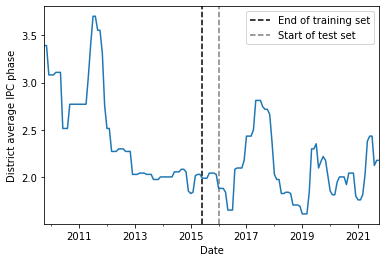

In [8]:
fig, ax = plt.subplots()
df_phase_fews_net.reset_index().groupby('date').mean().plot(y='area_phase', ax=ax, label='_nolegend_')
ax.set_xlabel('Date')
ax.set_ylabel('District average IPC phase');
ax.axvline(pd.to_datetime('2015-06-01'), color='black', linestyle='--', zorder=-10)
ax.axvline(pd.to_datetime('2016-01-01'), color='grey', linestyle='--', zorder=-10)
ax.legend(['End of training set', 'Start of test set'])

if export:
    fig.savefig('../figures/train_test_split.pdf', format='pdf')

In [138]:
def create_data(lead, weather=False, prices=False, full=False, no_counts=False, no_fsnau=False, splits=None):
    lags = []
    #idx = lead
    #for n in [4, 8, 12]: 
    for n in range(lead, lead + 6):
        lags.append(df_phase_fews_net.groupby('area')[
                    'area_phase'].shift(n).rename(f'IPC_l{n}'))
        #idx += 1

    lags = pd.concat(lags, axis=1)
    lags['CE'] = df_phase_fews_net['area_phase'] - lags[f'IPC_l{lead}']
    lags['mom'] = lags[f'IPC_l{lead}'] - lags[f'IPC_l{lead + 5}']

    X = lags
    if(weather or full):
        X = X.merge(weather_features, left_index=True,
                    right_index=True, how='outer')
    if(prices or full):
        if(not no_fsnau):
            X = X.merge(rolling_fsnau_mean, left_index=True,
                        right_index=True, how='outer')
        X = X.merge(df_wb[wb_price_cols], left_index=True, right_index=True)
    if(full):
        X = X.merge(df_wb[wb_cols], left_index=True, right_index=True)
    if(not no_counts):
        X['det_count'] = X['mom'].groupby(
            'area').apply(lambda x: (x > 0).cumsum())
        X['neu_count'] = X['mom'].groupby(
            'area').apply(lambda x: (x == 0).cumsum())
        X['imp_count'] = X['mom'].groupby(
            'area').apply(lambda x: (x < 0).cumsum())
        count_sum = X['det_count'] + X['neu_count'] + X['imp_count']
        X['det_count'] = X['det_count']/count_sum
        X['neu_count'] = X['neu_count']/count_sum
        X['imp_count'] = X['imp_count']/count_sum

    X['CE'] = ((X['CE'] < 0) * 1 + (X['CE'] > 0) * -1).astype('int8')
    X_cols = set(X.columns).difference(['CE'])
    if(full or weather or prices):
        X_cols_no_ipc = X_cols.difference(
            ['CE'] + list(lags.columns) + ['det_count', 'neu_count', 'imp_count'])
        X.loc[:, X_cols_no_ipc] = X.loc[:,
                                        X_cols_no_ipc].groupby('area').shift(lead)
    na_mask = X.isna().any(axis=1)
    X = X[~na_mask]
    months = get_date(X).month
    X['jilaal'] = (months >= 12) & (months <= 3)
    X['gu'] = (months >= 4) & (months <= 6)
    X['haggai'] = (months >= 7) & (months <= 9)
    X['deyr'] = (months >= 10) & (months <= 11)
    split_train = get_date(X) < pd.to_datetime('2015-06-01')
    split_test = get_date(X) >= pd.to_datetime('2016-01-01')
    if(splits):
        split_test = (get_date(X) >= splits[0]) & (get_date(X) < splits[1])
        split_train = ~split_test & (get_date(X) <= pd.to_datetime('2016-01-01'))
        print(f'test: {sum(split_test)}, train: {sum(split_train)}')
    X_train, y_train = X[split_train].loc[:,
                                          X_cols], X[split_train].loc[:, 'CE'] + 1
    X_test, y_test = X[split_test].loc[:,
                                       X_cols], X[split_test].loc[:, 'CE'] + 1
    return X_train, y_train, X_test, y_test


def perform_experiment(lead, seed, weather=False, prices=False, full=False, no_counts=False, no_fsnau=False, splits=None, hyp_dict=None):
    X_train, y_train, X_test, y_test = create_data(lead, weather, prices, full, no_counts, no_fsnau, splits)
    ada = ADASYN(random_state=seed)
    X_res, y_res = ada.fit_resample(X_train, y_train)

    if(not hyp_dict):
       xgc = xgb.XGBClassifier(objective='multi:softmax', use_label_encoder=False, max_depth=4, n_estimators=400, learning_rate=0.01,
                                subsample=0.45, colsample_bytree=0.75, gamma=0.1, min_child_weight=7, reg_alpha=0.00001, reg_lambda=10, seed=seed)
    else:
        xgc = xgb.XGBClassifier(objective='multi:softmax', n_estimators=400, use_label_encoder=False, subsample=0.45, colsample_bytree=0.75, reg_alpha=0.00001, reg_lambda=10, seed=seed, **hyp_dict)
    xgc.fit(X_res, y_res)
    return X_test, y_test, xgc


In [1]:
perfs = {'weather': [], 'prices': [], 'full': [], 'prices_no_fsnau': [], 'reduced': [], }
for lead in range(1, 13):
    X_test, y_test, xgc = perform_experiment(lead, weather=True, seed=seed)
    perfs['weather'].append([y_test, xgc.predict(X_test)])
    X_test, y_test, xgc = perform_experiment(lead, prices=True, seed=seed)
    perfs['prices'].append([y_test, xgc.predict(X_test)])
    X_test, y_test, xgc = perform_experiment(lead, prices=True, no_fsnau=True, seed=seed)
    perfs['prices_no_fsnau'].append([y_test, xgc.predict(X_test)])
    X_test, y_test, xgc = perform_experiment(lead, full=True, seed=seed)
    perfs['full'].append([y_test, xgc.predict(X_test)])
    X_test, y_test, xgc = perform_experiment(lead, seed=seed)
    perfs['reduced'].append([y_test, xgc.predict(X_test)])

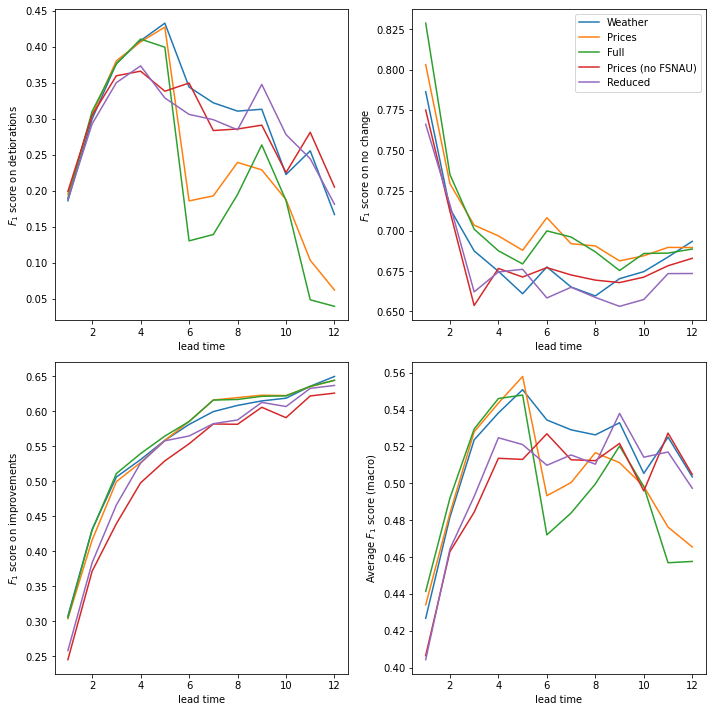

In [12]:
df_f1 = []
for model in perfs:
        for lead in range(1, 13):
                y_test, y_pred = perfs[model][lead-1]
                mask = get_date(y_test) <= pd.to_datetime('2020-02-01')
                df_f1.append([model, lead] + list(f1_score(y_test[mask], y_pred[mask], average=None)))
df_f1 = pd.DataFrame(df_f1)
df_f1.columns = ['Model', 'lead time', '$F_1$ score on detiorations', '$F_1$ score on no change', '$F_1$ score on improvements']
df_f1['Average $F_1$ score (macro)'] = df_f1.iloc[:, 2:].mean(axis=1)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
ax = ax.flatten()

sns.lineplot(data=df_f1, hue='Model', x='lead time', y='$F_1$ score on detiorations', ax=ax[0], legend=False)
sns.lineplot(data=df_f1, hue='Model', x='lead time', y='$F_1$ score on no change', ax=ax[1])
sns.lineplot(data=df_f1, hue='Model', x='lead time', y='$F_1$ score on improvements', ax=ax[2], legend=False)
sns.lineplot(data=df_f1, hue='Model', x='lead time', y='Average $F_1$ score (macro)', ax=ax[3], legend=False)
ax[1].legend(['Weather', 'Prices', 'Full', 'Prices (no FSNAU)', 'Reduced'])
plt.tight_layout()
if export:
        fig.savefig('../figures/f1_scores_3_window.pdf', format='pdf')

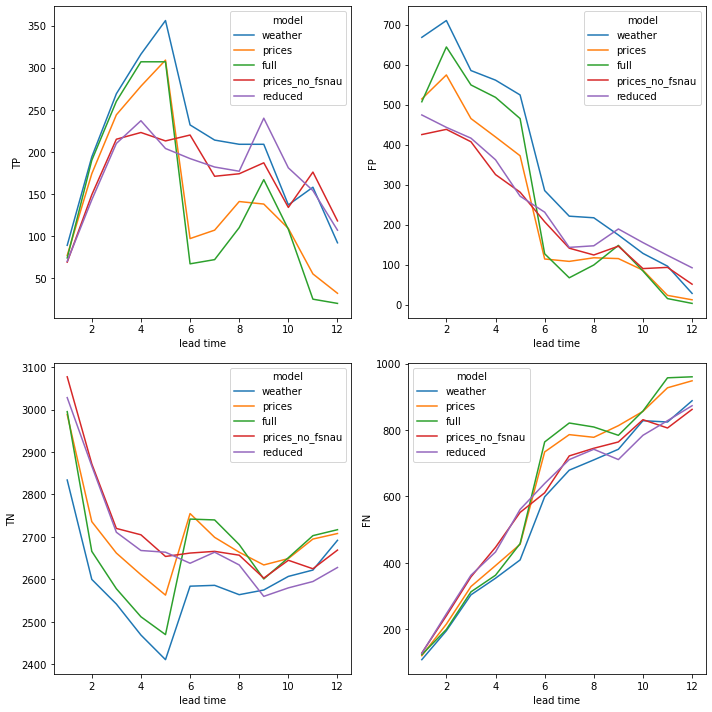

In [13]:
df_metrics = []
for model in perfs:
        for lead in range(1, 13):
                y_test, y_pred = perfs[model][lead-1]
                mask = get_date(y_test) <= pd.to_datetime('2020-02-01')
                c = confusion_matrix(y_test[mask], y_pred[mask])
                TP = c[0, 0]
                FP = c[[1, 2], 0].sum()
                TN = c[1:, 1:].sum()
                FN = c[0, [1, 2]].sum()
                df_metrics.append([model, lead] + [TP, FP, TN, FN])
df_metrics = pd.DataFrame(df_metrics)
df_metrics.columns = ['model', 'lead time', 'TP', 'FP', 'TN', 'FN']

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
ax = ax.flatten()

sns.lineplot(data=df_metrics, hue='model', x='lead time', y='TP', ax=ax[0])
sns.lineplot(data=df_metrics, hue='model', x='lead time', y='FP', ax=ax[1])
sns.lineplot(data=df_metrics, hue='model', x='lead time', y='TN', ax=ax[2])
sns.lineplot(data=df_metrics, hue='model', x='lead time', y='FN', ax=ax[3])
plt.tight_layout()
if export:
        fig.savefig('../figures/detioration_metrics_window_3.pdf', format='pdf')

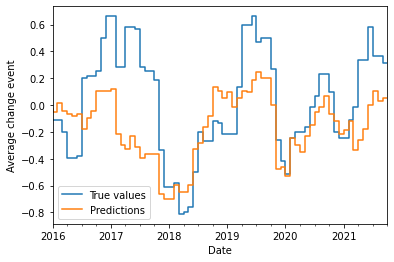

In [ ]:
fig, ax = plt.subplots()

lead = 7
X_test, y_test, xgc = perform_experiment(lead, seed=seed)
y_pred = xgc.predict(X_test)

test_df = pd.DataFrame(y_test.copy())
test_df['CE_pred'] = y_pred
test_df = (test_df-1)*-1
test_df.groupby('date').mean().plot(drawstyle='steps-pre', ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Average change event')
ax.legend(['True values', 'Predictions'])


fig.savefig('../figures/aggregate_perf_reduced.pdf', format='pdf')

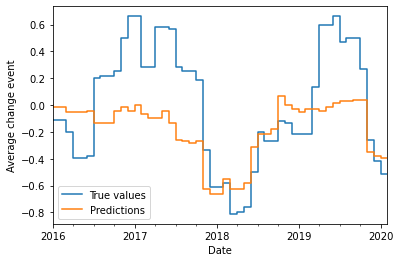

In [ ]:
fig, ax = plt.subplots()


lead = 7
X_test, y_test, xgc = perform_experiment(lead, full=True, seed=seed)
y_pred = xgc.predict(X_test)

test_df = pd.DataFrame(y_test.copy())
test_df['CE_pred'] = y_pred
test_df = (test_df-1)*-1
test_df.groupby('date').mean().plot(drawstyle='steps-pre', ax=ax)

ax.legend(['True values', 'Predictions'])
ax.set_xlabel('Date')
ax.set_ylabel('Average change event')

fig.savefig('../figures/aggregate_perf_full.pdf', format='pdf')

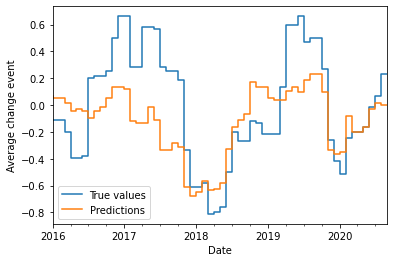

In [ ]:
fig, ax = plt.subplots()

lead = 7
X_test, y_test, xgc = perform_experiment(lead, weather=True, seed=seed)
y_pred = xgc.predict(X_test)

test_df = pd.DataFrame(y_test.copy())
test_df['CE_pred'] = y_pred
test_df = (test_df-1)*-1
test_df.groupby('date').mean().plot(drawstyle='steps-pre', ax=ax)

ax.legend(['True values', 'Predictions'])
ax.set_xlabel('Date')
ax.set_ylabel('Average change event')

fig.savefig('../figures/aggregate_perf_weather.pdf', format='pdf')

### Hyperparameter tuning

In [14]:
start = pd.to_datetime('2010-01-01')
end = pd.to_datetime('2016-01-01')
cutoff = (end-start)//3
folds = [[start, start + cutoff], [start + cutoff, start + cutoff*2], [start + cutoff*2, start +cutoff*3]]

In [2]:
max_depth = [2, 3, 4, 5]
min_child_weight = [5, 10, 15]
gamma = [0.01, 0.1, 1, 10]
learning_rate = [0.001, 0.01, 0.1]
hyperparameters = list(product(max_depth, min_child_weight, gamma, learning_rate))

df_hyper = []
lead = 8
for model in ['reduced', 'weather', 'prices_no_fsnau']:
    for hyper in hyperparameters:
        hyp_dict = {'max_depth': hyper[0], 'min_child_weight': hyper[1], 'gamma': hyper[2], 'learning_rate': hyper[3]}
        df_hyper.append([model] + list(hyper))
        for fold in folds:
            if model == 'weather':
                X_test, y_test, xgc = perform_experiment(lead, weather=True, seed=seed, no_counts=True, hyp_dict=hyp_dict, splits=fold)
            if model == 'prices_no_fsnau':
                X_test, y_test, xgc = perform_experiment(lead, prices=True, seed=seed, no_counts=True, no_fsnau=True, hyp_dict=hyp_dict, splits=fold)
            else:
                X_test, y_test, xgc = perform_experiment(lead, seed=seed, no_counts=True, hyp_dict=hyp_dict, splits=fold)
                            
            y_pred = xgc.predict(X_test)
            c = list(confusion_matrix(y_pred=y_pred, y_true=y_test))
            df_hyper[-1] += c
        
df_hyper = pd.DataFrame(df_hyper).copy()

In [242]:
results = []
for i in range(len(df_hyper)):
    conf_mat = np.vstack([df_hyper.iloc[i, 5:-1:3].sum(), df_hyper.iloc[i, 6:-1:3].sum(), df_hyper.iloc[i, 7:-1:3].sum()])
    results.append(conf_mat)
results = np.array(results)

In [249]:
TP_det = results[:, 0, 0]
FP_det = results[:, [1, 2], 0].sum(axis=(1))
FN_det = results[:, 0, [1, 2]].sum(axis=1)


TP_neu = results[:, 1, 1, ]
FP_neu = results[:, [0, 2], 1].sum(axis=(1))
FN_neu = results[:, 1, [0, 2]].sum(axis=1)


TP_imp = results[:, 2, 2, ]
FP_imp = results[:, [0, 1], 2].sum(axis=(1))
FN_imp = results[:, 2, [0, 1]].sum(axis=1)

In [245]:
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1 = 2 * (precision * recall)/(precision + recall)

In [250]:
def p_r_f1(TP, FP, FN):
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    f1 = 2 * (precision * recall)/(precision + recall)
    return precision, recall, f1

In [253]:
f1_det = p_r_f1(TP_det, FP_det, FN_det)[2]
f1_neu = p_r_f1(TP_neu, FP_neu, FN_neu)[2]
f1_imp = p_r_f1(TP_imp, FP_imp, FN_imp)[2]

In [ ]:
best_general_idx = np.vstack([f1_det, f1_neu, f1_imp]).mean(axis=0).argmax()
best_det_idx = f1_det.argmax()

In [294]:
print(np.vstack([f1_det, f1_neu, f1_imp])[:, best_general_idx].round(2))
print(np.vstack([f1_det, f1_neu, f1_imp])[:, best_det_idx].round(2))

array([0.27, 0.59, 0.71])

In [ ]:
print(df_hyper.iloc[best_general_idx, :5])
print(df_hyper.iloc[best_det_idx, :5])

In [324]:
hyp_dict = {'max_depth': 2, 'min_child_weight': 10, 'gamma': 0.01, 'learning_rate': 0.01}
X_test, y_test, xgc = perform_experiment(8, prices=True, seed=seed, no_counts=True, no_fsnau=True, hyp_dict=hyp_dict)

In [325]:
f1_score(y_test, xgc.predict(X_test), average=None).mean()

0.5274929385585483

In [326]:
hyp_dict = {'max_depth': 2, 'min_child_weight': 15, 'gamma': 0.01, 'learning_rate': 0.1}
X_test, y_test, xgc = perform_experiment(lead, seed=seed, no_counts=True, hyp_dict=hyp_dict)

In [327]:
f1_score(y_test, xgc.predict(X_test), average=None).mean()

0.547452929804245